In [179]:
import scanpy as sc
import anndata as an
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

In [156]:
# Load the reference and query datasets
yao = sc.read_h5ad('../data/exports/yao2023_cortex.h5ad')
demo = sc.read_h5ad('../data/exports/S315_demo.h5ad')
demo.var['gene_ids'] = demo.var['gene_ids'].str.split('.').str[0]
demo.var['gene_symbols'] = demo.var.index
demo.var.set_index('gene_ids', inplace=True)

In [157]:
# Ensure the datasets have common gene names
common_genes = yao.var.index.intersection(demo.var.index)

In [158]:
# Preprocess the reference dataset
yao_sub = yao[:, common_genes].copy()
sc.pp.normalize_total(yao_sub, target_sum=1e4)
sc.pp.log1p(yao_sub)
sc.pp.highly_variable_genes(yao_sub, n_top_genes=2000)
yao_sub = yao_sub[:, yao_sub.var.highly_variable].copy()
sc.pp.scale(yao_sub, max_value=10)

yao_sub.obs['class'] = yao_sub.obs['class'].astype('category')
yao_sub.obs['neurotransmitter'] = yao_sub.obs['neurotransmitter'].astype('category')
sc.tl.pca(yao_sub, svd_solver='arpack')
sc.pp.neighbors(yao_sub, n_neighbors=15, n_pcs=50)
sc.tl.umap(yao_sub)

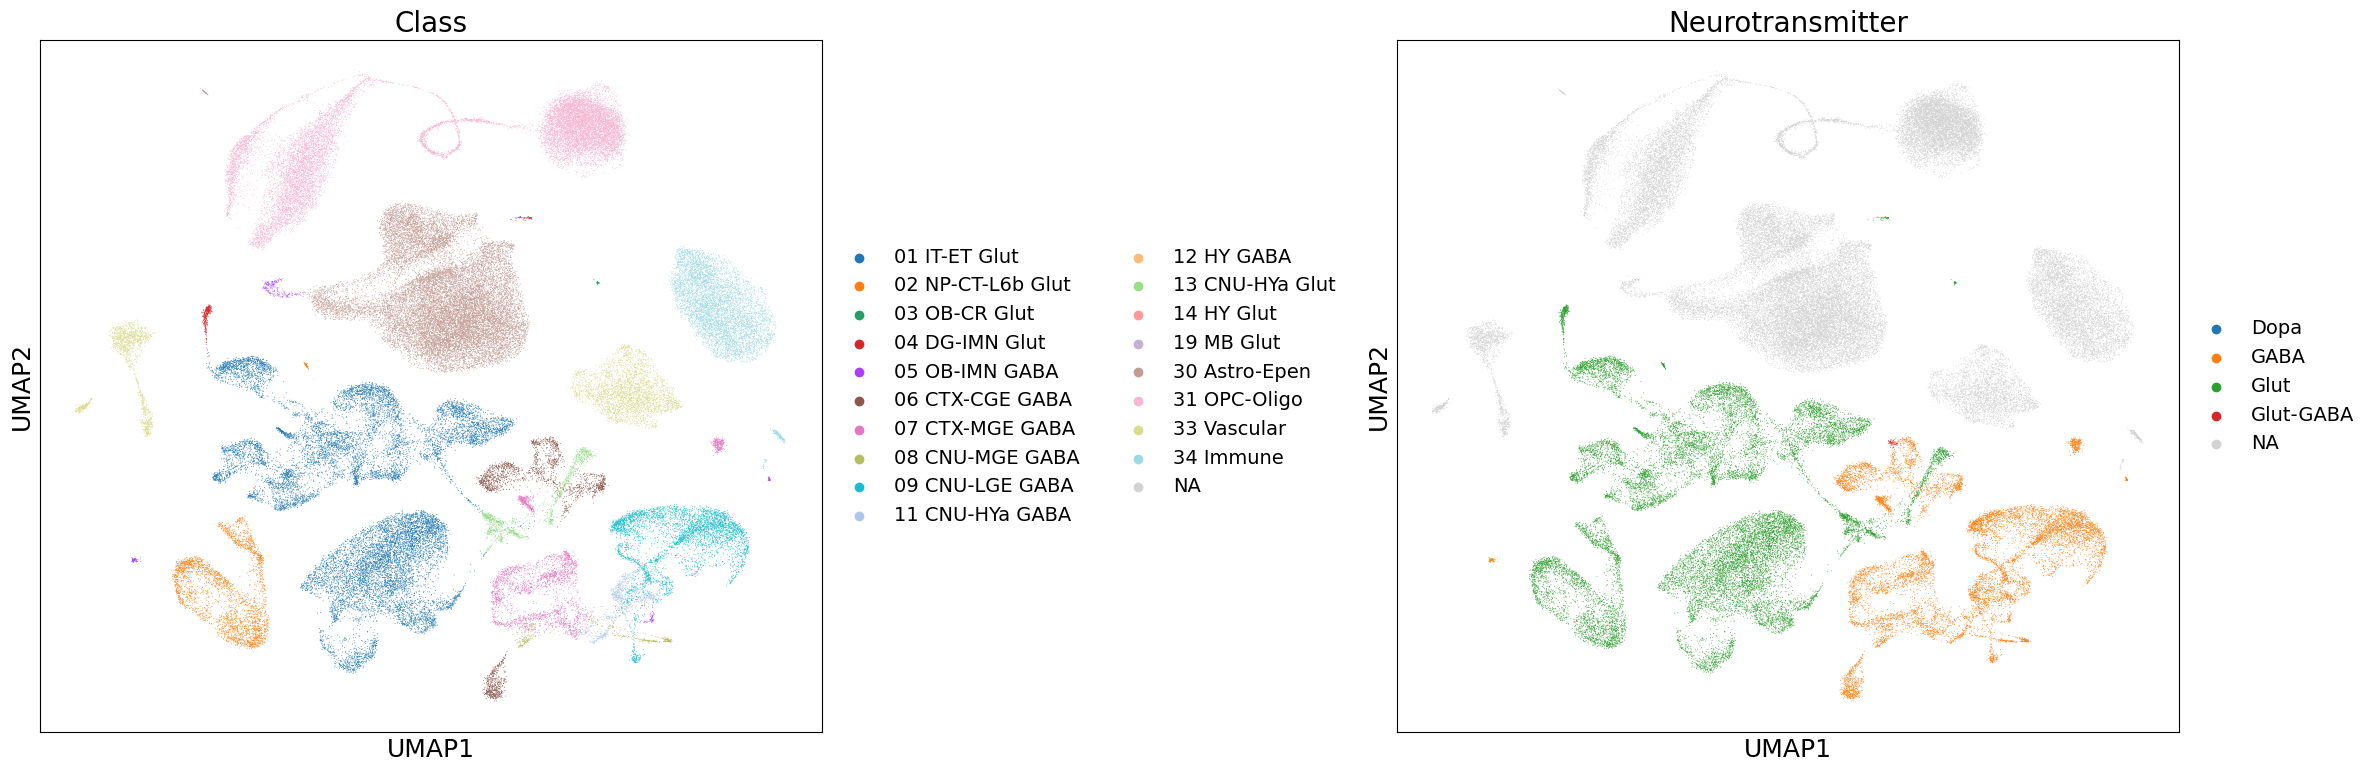

In [187]:
# plot reference
# Set global font sizes using matplotlib
plt.rcParams.update({
    'font.size': 16,          # Global font size
    'axes.titlesize': 20,     # Axes title font size
    'axes.labelsize': 18,     # Axes labels font size
    'xtick.labelsize': 16,    # X-axis tick label font size
    'ytick.labelsize': 16,    # Y-axis tick label font size
    'legend.fontsize': 14,    # Legend font size
})
#sc.pl.umap(yao_sub, color=["class", "neurotransmitter"], wspace=0.5)
fig, axes = plt.subplots(1, 2, figsize=(24, 8))  # Create subplots
sc.pl.umap(yao_sub, color='class', ax=axes[0], show=False, title='Class')
sc.pl.umap(yao_sub, color='neurotransmitter', ax=axes[1], show=False, title='Neurotransmitter')

plt.tight_layout()
fig.savefig("../assets/figureX_Yao2023.png", dpi=300)
plt.show()



In [160]:
# Preprocess the query dataset
demo_sub = demo[:, common_genes].copy()
# sc.pp.normalize_total(demo_sub, target_sum=1e2)
# sc.pp.log1p(demo_sub)
# sc.pp.scale(demo_sub, max_value=10)
# sc.tl.pca(demo_sub, svd_solver='arpack')
# sc.pp.neighbors(demo_sub, n_neighbors=15, n_pcs=50)
# sc.tl.umap(demo_sub)
demo_sub = demo_sub[:, yao_sub.var_names].copy()  # Align with reference data


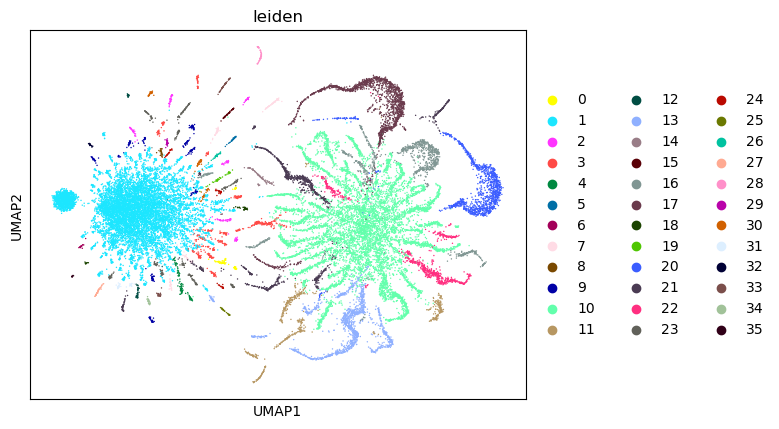

In [161]:
sc.pl.umap(demo_sub, color="leiden")

In [163]:
# Ingest the query dataset into the reference dataset
demo_test = demo_sub.copy()
yao_test = yao_sub.copy()
sc.tl.ingest(demo_test, yao_test, obs='class', embedding_method='umap')

/Users/tushevg/Desktop/syndrops/venv/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [176]:
# Extract UMAP coordinates
umap_coords = demo_test.obsm['X_umap']

# Calculate local density using KDE
kde = gaussian_kde(umap_coords.T)
density = kde(umap_coords.T)

# Add density to AnnData object
demo_test.obs['density'] = density

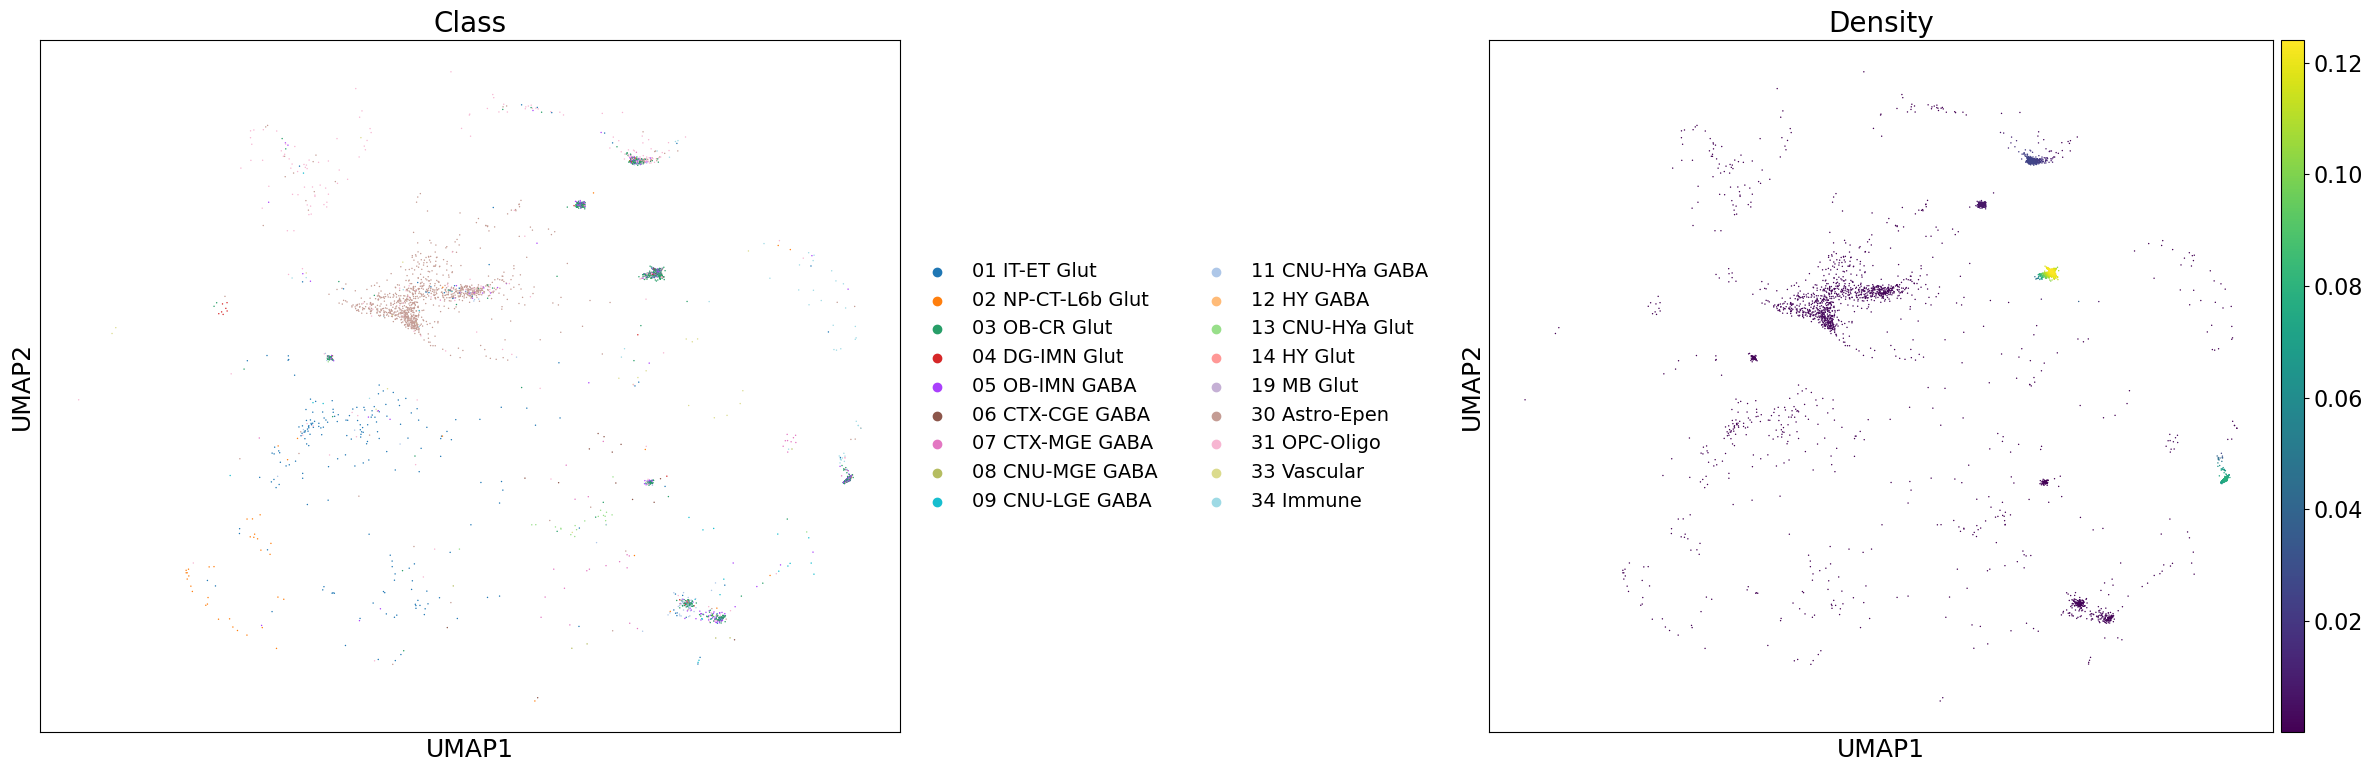

In [189]:
# sc.pl.umap(demo_test, color=['class', 'density'], wspace=0.5)


# Set global font sizes using matplotlib
plt.rcParams.update({
    'font.size': 16,          # Global font size
    'axes.titlesize': 20,     # Axes title font size
    'axes.labelsize': 18,     # Axes labels font size
    'xtick.labelsize': 16,    # X-axis tick label font size
    'ytick.labelsize': 16,    # Y-axis tick label font size
    'legend.fontsize': 14,    # Legend font size
})
#sc.pl.umap(yao_sub, color=["class", "neurotransmitter"], wspace=0.5)
fig, axes = plt.subplots(1, 2, figsize=(24, 8))  # Create subplots
sc.pl.umap(demo_test, color='class', ax=axes[0], show=False, title='Class')
sc.pl.umap(demo_test, color='density', ax=axes[1], show=False, title='Density')

plt.tight_layout()
fig.savefig("../assets/figureX_S315_embedded_Yao2023.png", dpi=300)
plt.show()



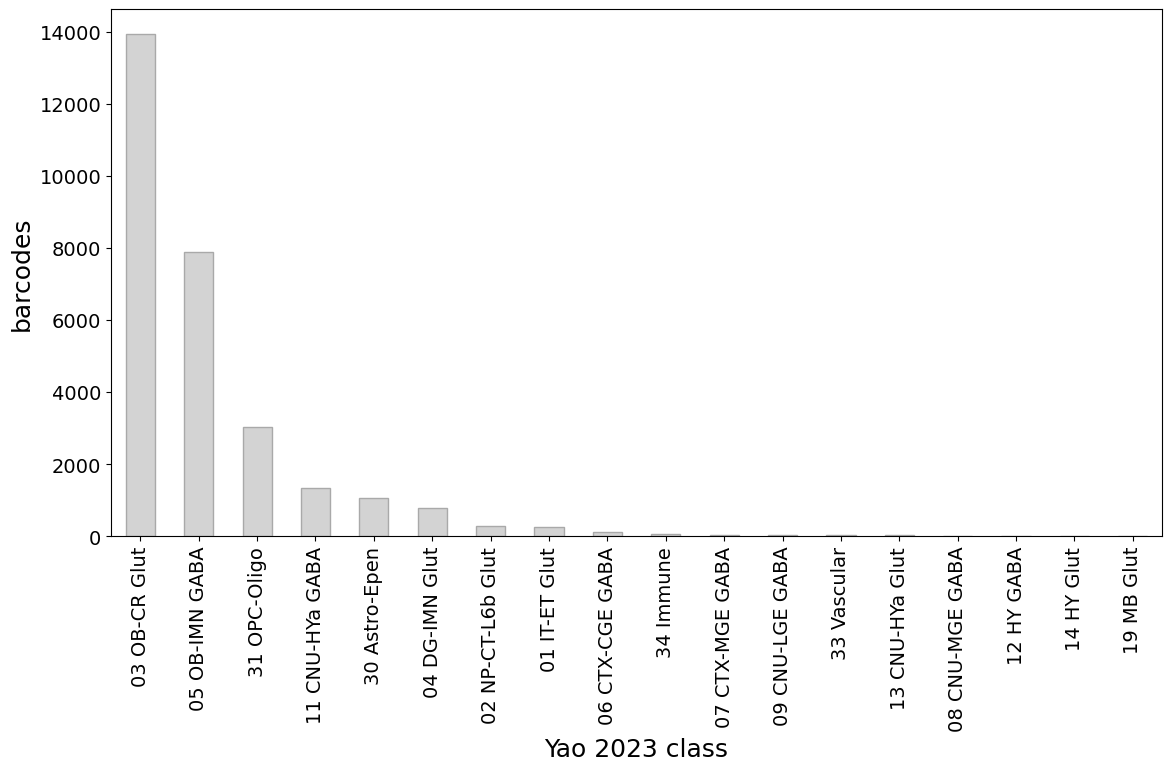

In [197]:
class_counts = demo_test.obs['class'].value_counts()


# Plot the bar plot
fig, ax = plt.subplots(figsize=(12, 8))
class_counts.plot(kind='bar', ax=ax, color='lightgray', edgecolor='darkgray')

# Customize the plot
ax.set_xlabel('Yao 2023 class', fontsize=18)
ax.set_ylabel('barcodes', fontsize=18)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Show the plot
plt.tight_layout()
fig.savefig("../assets/figureX_BarPlot_Yao2023Classes.png", dpi=300)
plt.show()

In [205]:
demo_redo = demo.copy()
print(demo_redo.shape)
print(demo_test.shape)
print(all(demo_redo.obs.index == demo_test.obs.index))
demo_redo.obs['class'] = demo_test.obs['class']
filter_mask = demo_redo.obs['class'].str.endswith('Glut') | demo_redo.obs['class'].str.endswith('GABA')
demo_redo = demo_redo[filter_mask]
print(demo_redo.shape)
sc.pp.highly_variable_genes(demo_redo, layer='log1p_norm', n_top_genes=3000, inplace=True)
sc.tl.pca(demo_redo, layer='log1p_norm', svd_solver='arpack', mask_var="highly_variable")
sc.pp.neighbors(demo_redo, n_pcs = 50, n_neighbors = 15, metric = 'cosine')
sc.tl.umap(demo_redo)

(28783, 9090)
(28783, 2000)
True
(24622, 9090)


/Users/tushevg/Desktop/syndrops/venv/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:664: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}


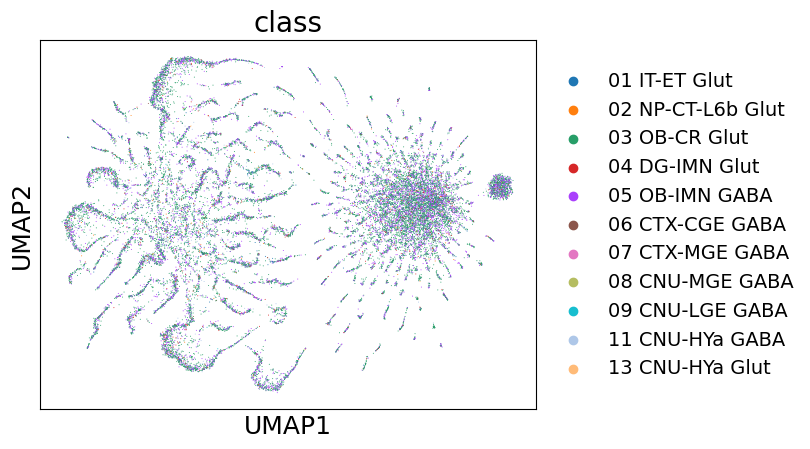

In [207]:
sc.pl.umap(demo_redo, size=2, color='class')